In [1]:
zip_dir = '/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/bbbcHumanMCF7cells/zip_files'

In [2]:
import glob
import shutil

In [3]:
img_dir = '/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/bbbcHumanMCF7cells/img_files'

In [4]:
'''
for zip_file in glob.glob(f'{zip_dir}/*.zip'):
    shutil.unpack_archive(zip_file, img_dir, 'zip')
    print(f'unzipping done : {zip_file}')
'''

"\nfor zip_file in glob.glob(f'{zip_dir}/*.zip'):\n    shutil.unpack_archive(zip_file, img_dir, 'zip')\n    print(f'unzipping done : {zip_file}')\n"

# CONT

In [5]:
import cv2
import matplotlib.pyplot as plt

In [6]:
import torch
import torchvision
import numpy as np

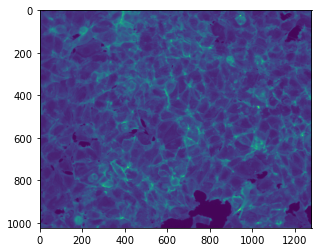

In [7]:
channel_type= ['w1', 'w2', 'w4'][2]

img_files = sorted(glob.glob(f'{img_dir}/*/*_{channel_type}*.tif'))

x_=[]
for img_file_dir in img_files:
    x_.append(plt.imread(img_file_dir))
    if len(x_)==16:break
    
x= torch.from_numpy(np.array(x_).astype('float')).unsqueeze(dim=1)
grid_img = torchvision.utils.make_grid(x[:16], nrow=4)
plt.imshow(cv2.cvtColor((grid_img.permute(1,2,0).numpy()).astype('uint16'), cv2.COLOR_RGB2GRAY))

plt.imshow(x_[np.random.randint(0, len(x_))])

# FIND RANGE


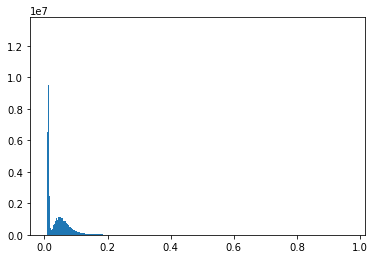

iter 0 :: confidence --> 99%:0.17749|99.9%:0.33081|100%:0.96753
iter 1 :: confidence --> 99%:0.17334|99.9%:0.31323|100%:0.96729
iter 2 :: confidence --> 99%:0.15845|99.9%:0.26733|100%:0.87842
iter 3 :: confidence --> 99%:0.16821|99.9%:0.29272|100%:0.96484
iter 4 :: confidence --> 99%:0.18115|99.9%:0.50952|100%:0.96777


In [8]:
def find_range(img_files):
    for _ in range(5):
        np.random.shuffle(img_files)
        imgs= []
        for i in range(len(img_files)):
            img_file_dir = img_files[i]
            img_array = plt.imread(img_file_dir)
            imgs.append(img_array)
            if i==50:break
        imgs= np.array(imgs).astype('float')/65536

        flatten_imgs= imgs.flatten()
        sorted_flatten= sorted(flatten_imgs)

        conf_mark1= sorted_flatten[int(0.99*len(flatten_imgs))]
        conf_mark2= sorted_flatten[int(0.999*len(flatten_imgs))]
        conf_mark3= sorted_flatten[-1]
        
        if _==0:
            plt.hist(flatten_imgs, bins= 500)
            plt.show()

        print(f'iter {_} :: confidence --> 99%:{np.round(conf_mark1, 5)}|99.9%:{np.round(conf_mark2, 5)}|100%:{np.round(conf_mark3, 5)}')

img_files= glob.glob(f'{img_dir}/*/*_{channel_type}*.tif')
find_range(img_files)

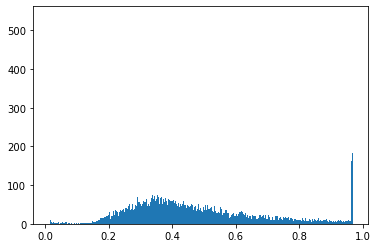

confidence --> 99%:0.96729|99.9%:0.96875|100%:0.96899


In [9]:
def find_maxes_range(img_files):
    maxes= []
    for i in range(len(img_files)):
        img_file_dir = img_files[i]
        img_array = plt.imread(img_file_dir)
        maxes.append(img_array.max())
    maxes= np.array(maxes).astype('float')/65536

    sorted_flatten= sorted(maxes)

    conf_mark1= sorted_flatten[int(0.99*len(maxes))]
    conf_mark2= sorted_flatten[int(0.999*len(maxes))]
    conf_mark3= sorted_flatten[-1]

    plt.hist(maxes, bins= 500)
    plt.show()

    print(f'confidence --> 99%:{np.round(conf_mark1, 5)}|99.9%:{np.round(conf_mark2, 5)}|100%:{np.round(conf_mark3, 5)}')

img_files= glob.glob(f'{img_dir}/*/*_{channel_type}*.tif')
find_maxes_range(img_files)

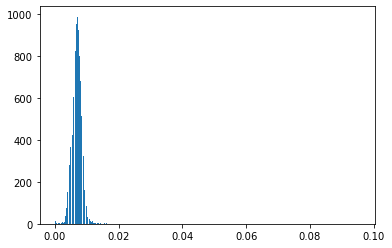

confidence --> 99%:0.00366|99.9%:0.0|100%:0.0


In [10]:
def find_minas_range(img_files):
    minas= []
    for i in range(len(img_files)):
        img_file_dir = img_files[i]
        img_array = plt.imread(img_file_dir)
        minas.append(img_array.min())
    minas= np.array(minas).astype('float')/65536

    sorted_flatten= sorted(minas, reverse=True)

    conf_mark1= sorted_flatten[int(0.99*len(minas))]
    conf_mark2= sorted_flatten[int(0.999*len(minas))]
    conf_mark3= sorted_flatten[-1]

    plt.hist(minas, bins= 500)
    plt.show()

    print(f'confidence --> 99%:{np.round(conf_mark1, 5)}|99.9%:{np.round(conf_mark2, 5)}|100%:{np.round(conf_mark3, 5)}')

img_files= glob.glob(f'{img_dir}/*/*_{channel_type}*.tif')
find_minas_range(img_files)

# CREATE DATASET

In [11]:
import os

In [12]:
def show_set(img_set):
    x= img_set.unsqueeze(dim=1)
    grid_img = torchvision.utils.make_grid(x[:16], nrow=4)
    img= cv2.cvtColor((grid_img.permute(1,2,0).numpy()*255.0).astype('uint8'), cv2.COLOR_RGB2GRAY)
    plt.imshow(img)
    plt.title(f'max : {np.round(img_set.max(), 4)} | min : {np.round(img_set.min(), 4)}')
    plt.show()

In [13]:
def save_imgs(img_files, channel_type, save_parent_dir, trainvaltest= 'train', show_patches= True):
    save_dir= f'{save_parent_dir}/{channel_type}/{trainvaltest}'
    try:shutil.rmtree(save_dir)
    except:pass
    os.mkdir(save_dir)
    
    for i in range(len(img_files)):
        img_file_dir = img_files[i]
        
        if i%20==0:print(f'saving ({i}/{len(img_files)}) ... : {img_file_dir}')

        img_array = plt.imread(img_file_dir)

        crop_start= np.random.randint(0,256)
        cropped_img= torch.from_numpy(img_array[:,crop_start:crop_start+1024].astype('float')/65535.0)
        cropped_set = cropped_img.reshape(4, 256, 4, 256).permute(0,2,1,3).flatten(start_dim=0, end_dim=1)

        if show_patches:show_set(cropped_set)
        #if i==0:img_set= cropped_set
        #else:img_set= torch.cat((img_set, cropped_set), dim=0)
        
        for j in range(16):
            #plt.imsave(f'{save_dir}/{i}_{j}.png', cropped_set[j])
            cv2.imwrite(f'{save_dir}/{i}_{j}.png', (cropped_set[j].numpy()*256).astype('uint8'))

In [14]:
save_parent_dir= '/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/bbbcHumanMCF7cells/preprocessed'

channel_type= ['w1', 'w2', 'w4'][2] # w1: nucleus
all_img_files = sorted(glob.glob(f'{img_dir}/*/*_{channel_type}*.tif'))

In [ ]:
np.random.shuffle(all_img_files)

save_imgs(all_img_files[:int(len(all_img_files)*0.98)], channel_type, save_parent_dir, trainvaltest= 'train', show_patches= False)
save_imgs(all_img_files[int(len(all_img_files)*0.98):int(len(all_img_files)*0.99)], channel_type, save_parent_dir, trainvaltest= 'val', show_patches= False)
save_imgs(all_img_files[int(len(all_img_files)*0.99):], channel_type, save_parent_dir, trainvaltest= 'test', show_patches= False)

0.19215687

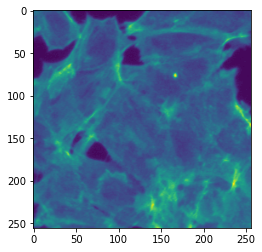

In [18]:
img= plt.imread('/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/bbbcHumanMCF7cells/preprocessed/w4/train/2_12.png')
plt.imshow(img)
img.max()

# CREATE DATALOADERS

total images found in: /n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/bbbcHumanMCF7cells/preprocessed/w4/train -> 206976
total images found in: /n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/bbbcHumanMCF7cells/preprocessed/w4/val -> 2112
total images found in: /n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/bbbcHumanMCF7cells/preprocessed/w4/test -> 2112


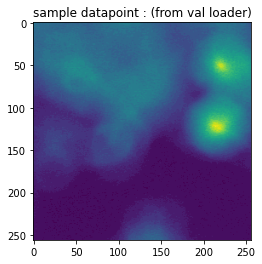

dataset value range :  0.003922564908862114 0.32941246032714844


In [19]:
import sys
sys.path.append('../')

from modules.datasets import *
from modules.data_utils import return_dataloaders

get_dataset_func= bbbcHumanMCF7cellsW4 #confocal #mnistdigits_grid2patch

img_size= 256
delta= 0.000001
num_samples_train= 10000
batch_size_train= 32

trainset, valset, testset = get_dataset_func(img_size= img_size, delta= delta, num_samples_train= num_samples_train)
train_loader, val_loader, test_loader = return_dataloaders(trainset, valset, testset, batch_size_train= batch_size_train)


In [20]:
x.max(), x.min()

(tensor(63376., dtype=torch.float64), tensor(416., dtype=torch.float64))

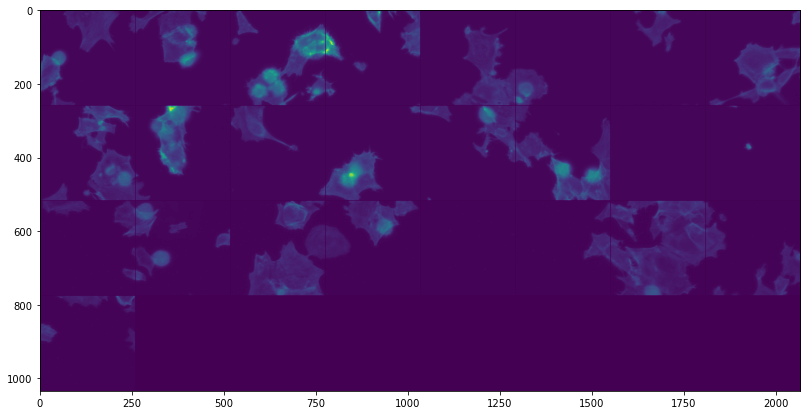

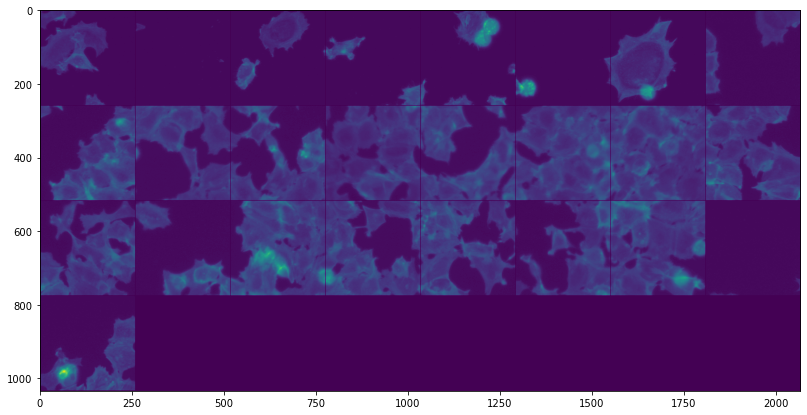

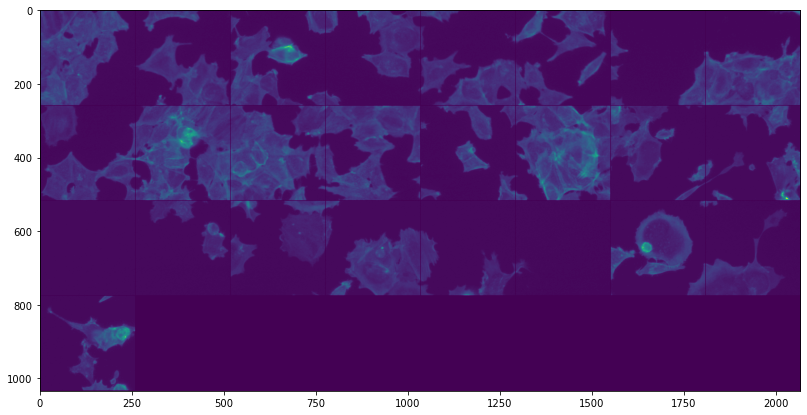

In [22]:
import cv2
for idx, (x, y) in enumerate(test_loader):
    if idx > 2:break
    #print(x.shape, y)
    grid_img = torchvision.utils.make_grid(x, nrow=8)
    plt.figure(figsize= (15, 7))
    plt.imshow(cv2.cvtColor(grid_img.permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY))
    plt.show()